In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from functions.ex_em_spectra import ex_spectrum, em_spectrum

from functions.optical_fiber import (
    cone_acceptance_angle,
    optical_fiber_head
)
from functions.points_and_washers import (
    pcr_tube_to_washers,
    volume_of_washers,
    generate_washer_points,
)

from functions.ray_tracing import (
    find_total_power,
    vector_plot
)

from functions.surfaces import (
    ellipsoid1,
    vertical_cone,
    vertical_cylinder
)

In [3]:
v = 100  # volume added to PCR tube (mm^3)
r, dz, height = pcr_tube_to_washers(80, v)  # function dividing this volume into 80 equivalent washers
volume_washers = volume_of_washers(r, dz)  # function summing up the incremental washer volumes
volume_difference = v - volume_washers  # difference between input volume and the volume of washers
print(f'Difference between real volume, and washer representation: {round(volume_difference, 2)} mm^3')
print(f'Height: {round(height, 2)} mm')  # height which the volume reaches wrt z=0

Difference between real volume, and washer representation: 6.92 mm^3
Height: 9.63 mm


Here we compare the parametric model of the PCR tube, which was developed based on the provided measurements compared to the approximation of the PCR tube using concentric washers, which allow us to measure discrete increments of light power absorption.

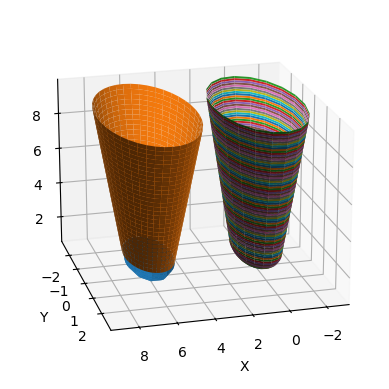

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_s1, y_s1, z_s1 = ellipsoid1(1.3080, 1.3080, 1.120, [0, 2 * np.pi], [np.pi / 2, np.pi], 6, 0, 0.721 + 1.120)
ax.plot_surface(x_s1, y_s1, z_s1)

x_co1, y_co1, z_co1 = vertical_cone(1.3080, 2.6645, height - 1.841, 6, 0, 1.841)
ax.plot_surface(x_co1, y_co1, z_co1)

for i in range(len(r)):
    top = height - dz * (i - 1)
    bottom = height - dz * i
    z1 = np.linspace(bottom, top, 2)
    rad = r[i]
    theta = np.linspace(0, 2 * np.pi, int(1 / 0.05))

    THETA, Z = np.meshgrid(theta, z1)
    x = rad * np.cos(THETA)
    y = rad * np.sin(THETA)
    z = Z

    ax.plot_surface(x, y, z)

ax.set_xlabel("X")
ax.set_ylabel("Y")

ax.view_init(20, 75)

plt.show()


Now given the model, we can generate uniformly points within each washer scaled to their individual volume proportion such that they are evenly dispersed:

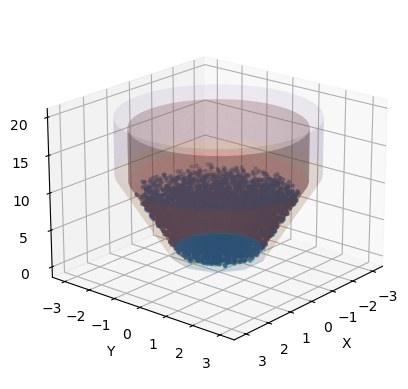

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_s, y_s, z_s = ellipsoid1(1.4695, 1.4695, 1.270, [0, 2 * np.pi], [np.pi / 2, np.pi], 0, 0, 1.270)
ax.plot_surface(x_s, y_s, z_s, alpha=0.1)

x_co, y_co, z_co = vertical_cone(1.4695, 3.068, 10.787, 0, 0, 1.270)
ax.plot_surface(x_co, y_co, z_co, alpha=0.1)

x_s2, y_s2, z_s2 = ellipsoid1(1.3080, 1.3080, 1.120, [0, 2 * np.pi], [np.pi / 2, np.pi], 0, 0, 0.721 + 1.120)
ax.plot_surface(x_s2, y_s2, z_s2, alpha=0.3)

x_co2, y_co2, z_co2 = vertical_cone(1.3080, 2.6645, 9.258, 0, 0, 0.721 + 1.120)
ax.plot_surface(x_co2, y_co2, z_co2, alpha=0.3)

cy1_x, cy1_y, cy1_z = vertical_cylinder(3.068, 7.638, 0, 0, 1.270 + 10.787)
cy2_x, cy2_y, cy2_z = vertical_cylinder(2.6645, 7.105, 0, 0, 0.721 + 1.120 + 9.258)

ax.plot_surface(cy1_x, cy1_y, cy1_z, alpha=0.1)
ax.plot_surface(cy2_x, cy2_y, cy2_z, alpha=0.3)

points = generate_washer_points(r, dz, height, 5000)
ax.scatter(points[:, 0], points[:, 1], points[:, 2], marker='.')

ax.view_init(20, 40)

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()


Now for each of the generated points in the volume, we can generate a set of vectors within a specified solid angle range of the direction of the optical fibre. For each vector we can use Snells Law to model the refraction at the water-cone, and cone-air interface. The endpoint vectors can then be assessed as being accepted by the optical fibre, based on the incidence angle, and location. Below shows a visualization with a small number of points displaying first, the accepted vectors in green, and then the non-accepted vectors in red:

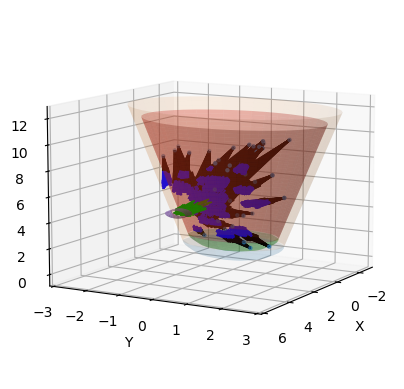

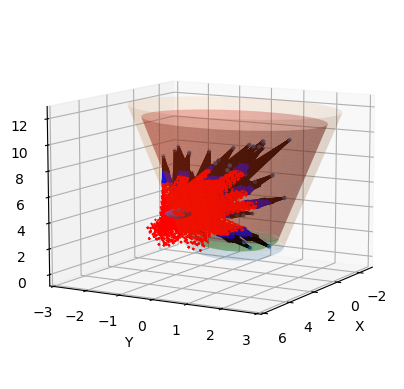

In [59]:
mid = [4, 0, 5]
acceptance_angle = 0.2218
radius = 0.3

# Generate points
points = generate_washer_points(r, dz, height, 40)

# Prepare data for plotting
all_initial = []
all_initial2 = []
all_accepted = []
all_not_accepted = []

for i in range(len(points)):
    initial, initial2, accepted, not_accepted = vector_plot(points[i], 40, mid, radius, acceptance_angle)
    all_initial.append(initial)
    all_initial2.append(initial2)
    all_accepted.append(accepted)
    all_not_accepted.append(not_accepted)

# Function to plot the base structure
def plot_base_structure(ax):
    x_s, y_s, z_s = ellipsoid1(1.4695, 1.4695, 1.270, [0, 2 * np.pi], [np.pi / 2, np.pi], 0, 0, 1.270)
    ax.plot_surface(x_s, y_s, z_s, alpha=0.1)

    x_co, y_co, z_co = vertical_cone(1.4695, 3.068, 10.787, 0, 0, 1.270)
    ax.plot_surface(x_co, y_co, z_co, alpha=0.1)

    x_s2, y_s2, z_s2 = ellipsoid1(1.3080, 1.3080, 1.120, [0, 2 * np.pi], [np.pi / 2, np.pi], 0, 0, 0.721 + 1.120)
    ax.plot_surface(x_s2, y_s2, z_s2, alpha=0.3)

    x_co2, y_co2, z_co2 = vertical_cone(1.3080, 2.6645, 9.258, 0, 0, 0.721 + 1.120)
    ax.plot_surface(x_co2, y_co2, z_co2, alpha=0.3)

    x_o, y_o, z_o = optical_fiber_head(mid, radius)
    ax.plot_surface(x_o, y_o, z_o)

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], marker='.')

    ax.set_ylim([-3, 3])
    ax.set_xlim([-3, mid[0] + 2])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

# Plot initial, initial2, and accepted vectors
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
plot_base_structure(ax1)

for i in range(len(points)):
    initial = all_initial[i]
    initial2 = all_initial2[i]
    accepted = all_accepted[i]

    ax1.quiver(initial[:, 0], initial[:, 1], initial[:, 2], initial[:, 3], initial[:, 4], initial[:, 5], color='k')
    ax1.quiver(initial2[:, 0], initial2[:, 1], initial2[:, 2], initial2[:, 3], initial2[:, 4], initial2[:, 5], color='b')
    ax1.quiver(accepted[:, 0], accepted[:, 1], accepted[:, 2], accepted[:, 3], accepted[:, 4], accepted[:, 5], color='g', linewidth=1)

ax1.view_init(10, 30)
plt.show()

# Plot initial, initial2, and not_accepted vectors
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
plot_base_structure(ax2)

for i in range(len(points)):
    initial = all_initial[i]
    initial2 = all_initial2[i]
    not_accepted = all_not_accepted[i]

    ax2.quiver(initial[:, 0], initial[:, 1], initial[:, 2], initial[:, 3], initial[:, 4], initial[:, 5], color='k')
    ax2.quiver(initial2[:, 0], initial2[:, 1], initial2[:, 2], initial2[:, 3], initial2[:, 4], initial2[:, 5], color='b')
    ax2.quiver(not_accepted[:, 0], not_accepted[:, 1], not_accepted[:, 2], not_accepted[:, 3], not_accepted[:, 4], not_accepted[:, 5], color='r', linestyle=':')

ax2.view_init(10, 30)
plt.show()


Instead, we can also just visualize individual points, and if they contain any vectors that are accepted. Additionally, we can explore the significance of the impact of refraction, by just displaying a cone representing the acceptance angle of the optical fibre. As we can see, generally the refraction in our current model does not cause for many points outside the initial angle to have accepted vectors, possibly indicating that isolating our analysis to points within that region could cause for improved computational efficiently as opposed to considering the entire volume.

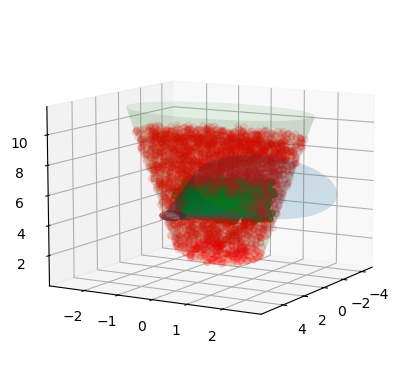

In [63]:
angles = [(10, 30)]

# Loop through each angle and plot the figures
for angle in angles:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surfaces
    x_cone, y_cone, z_cone = cone_acceptance_angle(acceptance_angle, mid, radius)
    ax.plot_surface(x_cone, y_cone, z_cone, alpha=0.2)

    x_s2, y_s2, z_s2 = ellipsoid1(1.3080, 1.3080, 1.120, [0, 2 * np.pi], [np.pi / 2, np.pi], 0, 0, 0.721 + 1.120)
    ax.plot_surface(x_s2, y_s2, z_s2, alpha=0.1)

    x_co2, y_co2, z_co2 = vertical_cone(1.3080, 2.6645, 9.258, 0, 0, 0.721 + 1.120)
    ax.plot_surface(x_co2, y_co2, z_co2, alpha=0.1)

    x_o, y_o, z_o = optical_fiber_head(mid, radius)
    ax.plot_surface(x_o, y_o, z_o)

    # Generate and plot points
    points = generate_washer_points(r, dz, height, 5000)

    a_points = np.zeros((len(points), 3))
    na_points = np.zeros((len(points), 3))

    counter_a = 1
    counter_na = 1

    for i in range(len(points)):
        initial, initial_2, accepted, not_accepted = vector_plot(points[i], 100, mid, radius, acceptance_angle)
        if len(accepted) == 0:
            na_points[counter_na - 1, :] = points[i]
            counter_na += 1
        else:
            a_points[counter_a - 1, :] = points[i]
            counter_a += 1

    a_points = a_points[:counter_a - 1, :]
    na_points = na_points[:counter_na - 1, :]

    ax.scatter(a_points[:, 0], a_points[:, 1], a_points[:, 2], color='g')
    ax.scatter(na_points[:, 0], na_points[:, 1], na_points[:, 2], color='r', alpha=0.1)

    # Set viewing angle
    ax.view_init(angle[0], angle[1])

    plt.show()  


In [4]:
mid = np.array([4, 0, 5])
acceptance_angle = 0.2218
radius = 0.3

lambda_ex = np.array([495, 535, 650])
lambda_em = np.array([516, 556, 670])

medians = np.array([486, 527, 524, 570, 636, 679])
median_intensities = np.array([0.8552, 0.8701, 0.7932, 0.7579, 0.8666, 0.8887])

Ex_co = np.array([[0.04229, 0.04558, 0.02026], [0.5072, 0.4951, 0.5773]])
Em_co = np.array([[0.03523, 0.06098, 0.02957], [0.4814, 0.3768, 0.5644]])

last_real_Ex = np.array([219, 257, 400])
Ex_max = np.array([518.646, 556.939, 699.358])
first_real_Em = np.array([189, 241, 338])
Em_min = np.array([487.615, 539.601, 636.182])

fun1 = ex_spectrum(Ex_co[0, 0], Ex_co[1, 0], lambda_ex[0])
fun2 = em_spectrum(Em_co[0, 0], Em_co[1, 0], lambda_em[0])

fun3 = ex_spectrum(Ex_co[0, 1], Ex_co[1, 1], lambda_ex[1])
fun4 = em_spectrum(Em_co[0, 1], Em_co[1, 1], lambda_em[1])

fun5 = ex_spectrum(Ex_co[0, 2], Ex_co[1, 2], lambda_ex[2])
fun6 = em_spectrum(Em_co[0, 2], Em_co[1, 2], lambda_em[2])

range_ = np.array([340, 780])
pixels = 256

power_factors = np.zeros(pixels)

import time
start_time = time.time()

for i in range(pixels):
    x = 340 + 1.7188 * (i - 1)  # wavelength value
    if Em_min[0] <= x <= Ex_max[0]:
        # within bounds of excitation and emission spectra
        power_factors[i] = find_total_power(1000, 100, 100, mid, radius, acceptance_angle, fun2(x), 0.9, 1, 83000 * fun1(x))
    elif x <= Ex_max[0]:
        # below max excitation but not above minimum emission
        power_factors[i] = 0
    elif x >= Em_min[0]:
        # greater than minimum emission but above maximum excitation
        power_factors[i] = find_total_power(1000, 200, 100, mid, radius, acceptance_angle, fun2(x), 0.9, 1, 0)

final_ratio = np.sum(power_factors)
end_time = time.time()

print(f"Final ratio: {final_ratio}")
print(f"Elapsed time: {end_time - start_time} seconds")


Final ratio: 1.2831621102324736e-05
Elapsed time: 453.89045000076294 seconds
